In [1]:
import sys
import os
from tqdm import tqdm

import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
print("PyTorch version: ", torch.__version__)
print("GPU Detected:" ,torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

#defining a shortcut function for later:
# import os
# using_GPU = os.path.exists('/opt/bin/nvidia-smi')

using_GPU = torch.cuda.is_available()


PyTorch version:  1.9.0+cu102
GPU Detected: True
GPU Device Name: NVIDIA GeForce MX150


In [3]:
dataFolderPath = os.path.join("data2_1")

In [4]:
trainingPercentage = 0.7
testPercentage = 0.3

In [5]:
folders = ["data2_1", "data2_2", "data2_3"]
csvLists = [glob.glob(f"{folder}/*.csv") for folder in folders]

In [6]:
# print(csvLists)

In [7]:
overallTrain = []
overallTest = []
for csvList in csvLists:  
  train, test = train_test_split(csvList,
                                test_size=testPercentage,
                                train_size=trainingPercentage)
  overallTrain.extend(train)
  overallTest.extend(test)

## Define and fine tune the pre-process function
Our dataset contains many columns we don't need

In [8]:
def preProcessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
  """
  Takes in a dataframe and returns another dataframe that contains only the data we want.
  Might wanna normalise the data as well
  Maybe fill the nulls with zeros or other appropriate values.
  """
  df_cp = df.copy()
  
#   df_cp.dropna(axis=0,
#                how='any', 
#                subset=["username", "tweet id"], 
#                inplace=True)
  
  df_cp = df_cp[["#followers",
                "#friends",
                "#retweets",
                "#favorites",
                "weekend",
                "entity_count",
                "hashtag_count",
                "mention_count",
                "url_count",
                "tlen",
                "ratio_fav_#followers",
                "time_importance",
                "sentiment_ppn",
                "sine_hour",
                "cosine_hour",
                "sine_day",
                "cosine_day",
                "sine_day_of_week",
                "cosine_day_of_week"
                ]]
  return df_cp


# sampleDf = pd.read_csv(overallTrain[0])
sampleDf = pd.read_csv(f"{dataFolderPath}/covid_data_1.csv")
# print(sampleDf.head())
print(sampleDf.info())
# [print(x) for x in sampleDf.columns] # show list of columns in sampleDf
print("\n====[AFTER PRE-PROCESSING]====\n")
# print(preProcessDataFrame(sampleDf.head()))
pp = preProcessDataFrame(sampleDf)
print(pp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10000 non-null  int64  
 1   tweet_id              10000 non-null  int64  
 2   username              10000 non-null  object 
 3   timestamp             10000 non-null  object 
 4   #followers            10000 non-null  float64
 5   #friends              10000 non-null  int64  
 6   #retweets             10000 non-null  int64  
 7   #favorites            10000 non-null  int64  
 8   entities              10000 non-null  object 
 9   sentiment             10000 non-null  object 
 10  mentions              9984 non-null   object 
 11  hashtags              9998 non-null   object 
 12  urls                  10000 non-null  object 
 13  timeseg               10000 non-null  int64  
 14  date                  10000 non-null  object 
 15  weekend             

In [9]:
class TwitterDataset(Dataset):
  def __init__(self, filenames, preProcessFunc = None):
    # `filenames` is a list of strings the contains all file names.
    # `batch_size` is the determines the number of files that we want to read in a chunk.
        self.filenames = filenames
        self.preProcess = preProcessFunc
  def __len__(self):
        return len(self.filenames)
  def __getitem__(self, idx): #idx means index of the chunk.
    # In this method, we do all the preprocessing.
    # First read data from files in a chunk. Preprocess it. Extract labels. Then return data and labels.
        csvFile = self.filenames[idx]
        df = pd.read_csv(csvFile)
        if self.preProcess:
          df = self.preProcess(df)

        x_arr = torch.Tensor(df.drop(columns=['#retweets']).to_numpy().astype(float))
        y = torch.Tensor(df["#retweets"].to_numpy().astype(float))
        X = torch.squeeze( x_arr )
        if idx == self.__len__():  
          raise IndexError
        return X, y
  def sample_df(self, idx = 0):
    return self[idx]

In [10]:
train_loader = DataLoader(dataset = TwitterDataset(overallTrain, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
                            
test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)

# Build the network
Make sure this network takes in whatever input you give it and outputs a number. Alternative, if this is an immediate model, like the zero/more than zero retweets classifier, than train it and save the parameters externally. Then train the regressor in another copy of this script.

In [11]:
class myNeuralNetwork(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(input_size, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(2048)
    self.batchnorm2 = nn.BatchNorm1d(512)
    self.batchnorm3 = nn.BatchNorm1d(128)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x

class myNeuralNetwork2(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork2, self).__init__()

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(256)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.batchnorm3 = nn.BatchNorm1d(64)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x
  

  0%|          | 0/5 [00:00<?, ?it/s]

Model on GPU?:
True


 20%|██        | 1/5 [09:00<36:03, 540.94s/it]

Epoch: 0, Loss: 1.325356364250183, 
MSELoss: 1.1803110837936401
Average MSELoss: 1.2068088177807075


 40%|████      | 2/5 [18:33<27:59, 559.76s/it]

Epoch: 1, Loss: 1.1497365236282349, 
MSELoss: 1.0409519672393799
Average MSELoss: 1.0391182294561843


 60%|██████    | 3/5 [28:27<19:10, 575.27s/it]

Epoch: 2, Loss: 0.7970351576805115, 
MSELoss: 0.8753089904785156
Average MSELoss: 0.8945234584414269


 80%|████████  | 4/5 [38:39<09:49, 589.82s/it]

Epoch: 3, Loss: 0.7956405878067017, 
MSELoss: 1.019895076751709
Average MSELoss: 1.0527362577186143


100%|██████████| 5/5 [50:33<00:00, 606.70s/it]

Epoch: 4, Loss: 0.583283007144928, 
MSELoss: 1.4968904256820679
Average MSELoss: 1.5500206781812935


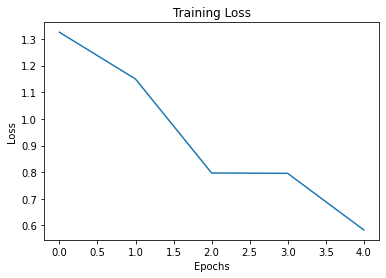

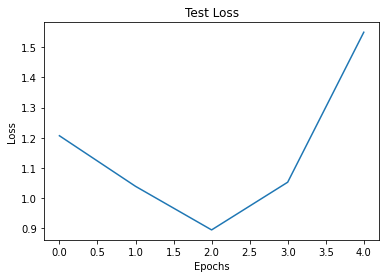

In [12]:
numEpochs = 5
lr_rate = 1e-3

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/

train_loss_lst = []
test_loss_lst_1 = []
for m in tqdm(range(numEpochs)):
    model.train()
    for X, y in train_loader:

        X = torch.squeeze(X).cuda()
        y = y.T.cuda()

        optimizer.zero_grad() 
        y_hat = model(X)
        y_log = torch.log(y+1)
        loss = loss_function(y_hat, y_log) #calculate the loss
        loss.backward() #backprop
        optimizer.step() #does the update

    train_loss_lst.append(loss.cpu().data.numpy())

    model.eval()
    
    test_loss_lst = []
    for (n, (X, y)) in enumerate(test_loader):
        X = torch.squeeze(X).cuda()
        y = y.T.cuda()
        y_hat = model(X)
        y_log = torch.log(y+1)
        test_loss = loss_function(y_hat, y_log)
        test_loss_lst.append(test_loss.cpu().data.numpy())
        
    if m % 1 == 0:
        print ("Epoch: {0}, Loss: {1}, ".format(m, loss.cpu().data.numpy()))
        print(f"MSELoss: {test_loss}")
        avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
        test_loss_lst_1.append(avgMSELoss)
        print(f"Average MSELoss: {avgMSELoss}")

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_lst)
plt.show()

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(test_loss_lst_1)
plt.show()

In [13]:
now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")

PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

print(PATH)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

PATH1 = "model_{0}.pt".format(d4)

pd.DataFrame(train_loss_lst).to_csv("model_loss_graph/train_loss_" + PATH1 +"_1" + '.csv')
pd.DataFrame(test_loss_lst_1).to_csv("model_loss_graph/test_loss_" + PATH1 +"_1"  + '.csv')

model/model_20210808_151123.pt


In [14]:
numEpochs = 6
lr_rate = 1e-3

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/

train_loss_lst2 = []
test_loss_lst_2 = []
for m in tqdm(range(numEpochs)):
    model.train()
    for X, y in train_loader:

        X = torch.squeeze(X).cuda()
        y = y.T.cuda()

        optimizer.zero_grad() 
        y_hat = model(X)
        y_log = torch.log(y+1)
        loss = loss_function(y_hat, y_log) #calculate the loss
        loss.backward() #backprop
        optimizer.step() #does the update

    train_loss_lst2.append(loss.cpu().data.numpy())

    model.eval()
    
    test_loss_lst = []
    for (n, (X, y)) in enumerate(test_loader):
        X = torch.squeeze(X).cuda()
        y = y.T.cuda()
        y_hat = model(X)
        y_log = torch.log(y+1)
        test_loss = loss_function(y_hat, y_log)
        test_loss_lst.append(test_loss.cpu().data.numpy())
        
    if m % 1 == 0:
        print ("Epoch: {0}, Loss: {1}, ".format(m, loss.cpu().data.numpy()))
        print(f"MSELoss: {test_loss}")
        avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
        test_loss_lst_2.append(avgMSELoss)
        print(f"Average MSELoss: {avgMSELoss}")

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_lst2)
plt.show()

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(test_loss_lst_2)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

Model on GPU?:
True


 17%|█▋        | 1/6 [13:24<1:07:02, 804.57s/it]

Epoch: 0, Loss: 1.141661524772644, 
MSELoss: 1.1171451807022095
Average MSELoss: 1.0867950761613767


 33%|███▎      | 2/6 [27:19<54:49, 822.27s/it]  

Epoch: 1, Loss: 1.036860466003418, 
MSELoss: 0.8753024935722351
Average MSELoss: 0.8879083989080319


 50%|█████     | 3/6 [41:35<41:53, 837.67s/it]

Epoch: 2, Loss: 0.8871827721595764, 
MSELoss: 0.7106202244758606
Average MSELoss: 0.6563438868719684


 67%|██████▋   | 4/6 [55:57<28:14, 847.31s/it]

Epoch: 3, Loss: 0.621474027633667, 
MSELoss: 1.612228512763977
Average MSELoss: 1.5864537893247999


 83%|████████▎ | 5/6 [1:10:46<14:22, 862.27s/it]

Epoch: 4, Loss: 0.7375091314315796, 
MSELoss: 1.3778566122055054
Average MSELoss: 1.408308921372595


In [ ]:
now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")

PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

print(PATH)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

PATH1 = "model_{0}.pt".format(d4)

pd.DataFrame(train_loss_lst2).to_csv("model_loss_graph/train_loss_" + PATH1 +"_2" + '.csv')
pd.DataFrame(test_loss_lst_2).to_csv("model_loss_graph/test_loss_" + PATH1 +"_2"  + '.csv')

In [ ]:
numEpochs = 3
lr_rate = 1e-3

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/

train_loss_lst3 = []
test_loss_lst_3 = []
for m in tqdm(range(numEpochs)):
    model.train()
    for X, y in train_loader:

        X = torch.squeeze(X).cuda()
        y = y.T.cuda()

        optimizer.zero_grad() 
        y_hat = model(X)
        y_log = torch.log(y+1)
        loss = loss_function(y_hat, y_log) #calculate the loss
        loss.backward() #backprop
        optimizer.step() #does the update

    train_loss_lst3.append(loss.cpu().data.numpy())

    model.eval()
    
    test_loss_lst = []
    for (n, (X, y)) in enumerate(test_loader):
        X = torch.squeeze(X).cuda()
        y = y.T.cuda()
        y_hat = model(X)
        y_log = torch.log(y+1)
        test_loss = loss_function(y_hat, y_log)
        test_loss_lst.append(test_loss.cpu().data.numpy())
        
    if m % 1 == 0:
        print ("Epoch: {0}, Loss: {1}, ".format(m, loss.cpu().data.numpy()))
        print(f"MSELoss: {test_loss}")
        avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
        test_loss_lst_3.append(avgMSELoss)
        print(f"Average MSELoss: {avgMSELoss}")

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_lst3)
plt.show()

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(test_loss_lst_3)
plt.show()

now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")

PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

print(PATH)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

PATH1 = "model_{0}.pt".format(d4)

pd.DataFrame(train_loss_lst3).to_csv("model_loss_graph/train_loss_" + PATH1 +"_3" + '.csv')
pd.DataFrame(test_loss_lst_3).to_csv("model_loss_graph/test_loss_" + PATH1 +"_3"  + '.csv')